In [1]:
!pip install bio

     |████████████████████████████████| 271 kB 42.3 MB/s 
     |████████████████████████████████| 2.3 MB 8.5 MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, normalize
import os
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [5]:
# settings

data_path = "drive/My Drive/CS582/topic1-data/"
batch_size = 1
validation_ratio = 0.2

In [31]:
train_data_path = data_path + "SIN3A/SIN3A-train-sequence.fa"
test_data_path = data_path + "SIN3A/SIN3A-test-sequence.fa"
train_label_path = data_path + "SIN3A/SIN3A-train.bed"
test_label_path = data_path + "SIN3A/SIN3A-test.bed"
pwm_path = data_path + "SIN3A/"

In [7]:
def get_tf_list(data_path):
  tf_list = os.listdir(data_path)
  for tf in tf_list:
      if not os.path.isdir(data_path+tf):
          tf_list.remove(tf)
  return tf_list

In [11]:
def read_pwms(data_path):
  pwm_list = []
  for file in os.listdir(data_path):
    if file.endswith(".wtmx"):
        pwm_list.append(data_path+file)
  pwm_matrices = [normalize(pd.read_csv(pwm, names = ['A', 'T', 'C', 'G'], sep="\t", header=None,
                          skiprows=1, skipfooter=1, dtype='float32', engine='python')
                          .to_numpy(), axis=1, norm='l1')
                          for pwm in pwm_list]
  return pwm_matrices

In [32]:
pwm_matrices = read_pwms(pwm_path)

In [13]:
def one_hot_encoder(sequence):
   encoder = OneHotEncoder(sparse=False, dtype=int, handle_unknown='ignore')
   encoder.fit([['A'], ['T'], ['C'], ['G']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [14]:
class TFBindingDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TFBindingDataset, self).__init__()
        self.X = [np.array(list(record.seq.__str__().upper())).reshape(-1, 1) for record in SeqIO.parse(data_path, "fasta")]
        self.X = np.array([one_hot_encoder(data) for data in self.X]).astype('float32')
        shape = self.X.shape
        self.X = torch.as_tensor(self.X.reshape(shape[0], 1, shape[1], shape[2]))
        self.y = pd.read_csv(label_path, sep='\t', header=None).drop(labels=0, axis=1).to_numpy(dtype=float)

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

In [16]:
tf_list = get_tf_list(data_path)

In [33]:
train_set = TFBindingDataset(train_data_path, train_label_path) 
test_set = TFBindingDataset(test_data_path, test_label_path)  
#train_set, val_set = random_split(train_set, [int(len(train_set)*(1 - validation_ratio)), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
#val_loader = DataLoader(dataset=val_set,
 #                         batch_size=batch_size,
 #                         shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

In [34]:
y_true_train = []
y_true_test = []
sequence = []

for data in train_loader:
    X, y = data
    y_true_train.extend(torch.reshape(y, (-1,))) 
    sequence.extend(X[0][0])

for data in test_loader:
    _, y = data
    y_true_test.extend(torch.reshape(y, (-1,))) 
 
y_true_train = torch.stack(y_true_train)
y_true_test = torch.stack(y_true_test)
sequence = torch.stack(sequence)

In [18]:
def get_symbol_ratio(sequence):
  seq_shape = sequence.shape
  atcg_ratio = np.sum(sequence, axis=0)/(seq_shape[0])
  return atcg_ratio

In [19]:
def get_max_llr_score(data_loader, pwm_matrices, atcg_ratio):
  max_llr_score = []
  for data in data_loader:
      X, y = data 
      seq = X[0][0]
      score = y[0][0]
      max_score = torch.tensor(-float('inf'))
      for pwm in pwm_matrices:
        window_size = pwm.shape[0]
        w_base = torch.tile(torch.from_numpy(atcg_ratio), (window_size, 1))
        for i in range(seq.shape[0] - window_size+1):
            llr = torch.sum(torch.log(torch.max(torch.mul(torch.from_numpy(pwm), seq[i:i+window_size]), axis=1)[0])) - torch.sum(torch.log(torch.max(torch.mul(w_base, seq[i:i+window_size]), axis=1)[0]))
            max_score = torch.max(llr, max_score)
      max_llr_score.append(max_score.item())
  return max_llr_score

In [20]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)
    return accuracy, sensitivity, specificity, f1_score

In [35]:
atcg_ratio = get_symbol_ratio(sequence.numpy())

In [55]:
max_llr_score_train = get_max_llr_score(train_loader, pwm_matrices, atcg_ratio)

In [56]:
max_llr_score_test = get_max_llr_score(test_loader, pwm_matrices, atcg_ratio)

In [57]:
max_llr_score_train = np.nan_to_num(max_llr_score_train)
max_llr_score_test = np.nan_to_num(max_llr_score_test)
max_llr_threshold = np.median(max_llr_score_train)
binding_threshold = np.median(y_true_train)

max_llr_score_test_binary = (max_llr_score_test > max_llr_threshold)*1
max_llr_score_train_binary = (max_llr_score_train > max_llr_threshold)*1
y_true_test_binary = (y_true_test > binding_threshold)*1
y_true_train_binary = (y_true_train > binding_threshold)*1

In [30]:
binding_threshold

52.0

In [31]:
max_llr_threshold

8.597409751248932

In [26]:
np.median(max_llr_score_train)

nan

In [32]:
classification_statistics(y_true_test_binary, max_llr_score_test_binary)

[[105 138]
 [ 73  84]]
              precision    recall  f1-score   support

           0       0.59      0.43      0.50       243
           1       0.38      0.54      0.44       157

    accuracy                           0.47       400
   macro avg       0.48      0.48      0.47       400
weighted avg       0.51      0.47      0.48       400

=== Statistics ===
Test Accuracy: 0.472
Test Sensitivity: 0.535
Test Specificity: 0.432
Test F1-Score: 0.443


(0.4725, 0.535031847133758, 0.43209876543209874, 0.44327176781002636)

In [34]:
tf_list = get_tf_list(data_path)
df_metrics = pd.DataFrame(columns=['Metric'] + tf_list)
df_metrics['Metric'] = ['Accuracy', 'Sensitivity', 'Specificity', 'F1_score', 'ROC-AUC']

In [35]:
df_metrics

,Metric,TCF3,SIN3A,PAX5,BATF,BCL3,RUNX3,MEF2A,ZEB1,MXI1,NFYB,IKZF1,YY1,SPI1,RELA,NFATC1,USF1,ELF1,MAX,BHLHE40,EBF1,ZNF143,USF2,NFIC,TCF12,REST,EGR1
0,Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sensitivity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Specificity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F1_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ROC-AUC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
for i in range(5):
    for j in range(5):
        tf = tf_list[5*i+j]
        print("***************** " + tf + " *****************")
        train_data_path = data_path + tf + '/' + tf + '-train-sequence.fa'
        test_data_path = data_path + tf + '/' + tf + "-test-sequence.fa"
        train_label_path = data_path + tf + '/' + tf + "-train.bed"
        test_label_path = data_path + tf + '/' + tf + "-test.bed"
        pwm_path = data_path + tf + '/'

        pwm_matrices = read_pwms(pwm_path)

        train_set = TFBindingDataset(train_data_path, train_label_path) 
        test_set = TFBindingDataset(test_data_path, test_label_path)  

        train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
        test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)
        
        y_true_train = []
        y_true_test = []
        sequence = []

        for data in train_loader:
            X, y = data
            y_true_train.extend(torch.reshape(y, (-1,))) 
            sequence.extend(X[0][0])

        for data in test_loader:
            _, y = data
            y_true_test.extend(torch.reshape(y, (-1,))) 
        
        y_true_train = torch.stack(y_true_train)
        y_true_test = torch.stack(y_true_test)
        sequence = torch.stack(sequence)

        atcg_ratio = get_symbol_ratio(sequence.numpy())
        max_llr_score_train = get_max_llr_score(train_loader, pwm_matrices, atcg_ratio)
        max_llr_score_test = get_max_llr_score(test_loader, pwm_matrices, atcg_ratio)

        max_llr_score_train = np.nan_to_num(max_llr_score_train)
        max_llr_score_test = np.nan_to_num(max_llr_score_test)

        max_llr_threshold = np.median(max_llr_score_train)
        binding_threshold = np.median(y_true_train)

        max_llr_score_test_binary = (max_llr_score_test > max_llr_threshold)*1
        max_llr_score_train_binary = (max_llr_score_train > max_llr_threshold)*1
        y_true_test_binary = (y_true_test > binding_threshold)*1
        y_true_train_binary = (y_true_train > binding_threshold)*1

        accuracy, sensitivity, specificity, f1_score = classification_statistics(y_true_test_binary, max_llr_score_test_binary)
        auc = roc_auc_score(y_true_test_binary, max_llr_score_test_binary)
        df_metrics[tf] = [accuracy, sensitivity, specificity, f1_score, auc]

***************** TCF3 *****************
['drive/My Drive/CS582/topic1-data/TCF3/TCF3_GM12878_1.wtmx', 'drive/My Drive/CS582/topic1-data/TCF3/TCF3_GM12878_3.wtmx', 'drive/My Drive/CS582/topic1-data/TCF3/TCF3_GM12878_2.wtmx', 'drive/My Drive/CS582/topic1-data/TCF3/TCF3_GM12878_4.wtmx', 'drive/My Drive/CS582/topic1-data/TCF3/TCF3_GM12878_5.wtmx', 'drive/My Drive/CS582/topic1-data/TCF3/TCF3_FB_1.wtmx']
[[101 106]
 [109  84]]
              precision    recall  f1-score   support

           0       0.48      0.49      0.48       207
           1       0.44      0.44      0.44       193

    accuracy                           0.46       400
   macro avg       0.46      0.46      0.46       400
weighted avg       0.46      0.46      0.46       400

=== Statistics ===
Test Accuracy: 0.463
Test Sensitivity: 0.435
Test Specificity: 0.488
Test F1-Score: 0.439
***************** SIN3A *****************
['drive/My Drive/CS582/topic1-data/SIN3A/SIN3A_GM12878_5.wtmx', 'drive/My Drive/CS582/topic1-dat

In [37]:
df_metrics

,Metric,TCF3,SIN3A,PAX5,BATF,BCL3,RUNX3,MEF2A,ZEB1,MXI1,NFYB,IKZF1,YY1,SPI1,RELA,NFATC1,USF1,ELF1,MAX,BHLHE40,EBF1,ZNF143,USF2,NFIC,TCF12,REST,EGR1
0,Accuracy,0.462500,0.495000,0.517500,0.515000,0.512500,0.500000,0.505000,0.465000,0.527500,0.515000,0.497500,0.555000,0.515000,0.520000,0.492500,0.502500,0.505000,0.550000,0.497500,0.577500,0.487500,0.497500,0.525000,0.505000,0.560000,NaN
1,Sensitivity,0.435233,0.456647,0.489474,0.490291,0.424731,0.500000,0.457265,0.417526,0.547486,0.340426,0.455128,0.490323,0.523810,0.441558,0.472637,0.468966,0.431818,0.513812,0.566879,0.496774,0.477707,0.436047,0.543147,0.450777,0.288732,NaN
2,Specificity,0.487923,0.524229,0.542857,0.541237,0.588785,0.500000,0.572289,0.509709,0.511312,0.610039,0.524590,0.595918,0.507109,0.569106,0.512563,0.521569,0.594444,0.579909,0.452675,0.628571,0.493827,0.543860,0.507389,0.555556,0.709302,NaN
3,F1_score,0.438642,0.438889,0.490765,0.510101,0.447592,0.484536,0.519417,0.430851,0.509091,0.331034,0.413994,0.460606,0.505102,0.414634,0.483461,0.405970,0.489691,0.508197,0.469657,0.476780,0.422535,0.427350,0.529703,0.467742,0.317829,NaN
4,ROC-AUC,0.461578,0.490438,0.516165,0.515764,0.506758,0.500000,0.514777,0.463617,0.529399,0.475232,0.489859,0.543120,0.515459,0.505332,0.492600,0.495267,0.513131,0.546860,0.509777,0.562673,0.485767,0.489953,0.525268,0.503166,0.499017,NaN


In [38]:
df_metrics.set_index('Metric').T.sort_values('F1_score', ascending=False)

Metric,Accuracy,Sensitivity,Specificity,F1_score,ROC-AUC
NFIC,0.525,0.543147,0.507389,0.529703,0.525268
MEF2A,0.505,0.457265,0.572289,0.519417,0.514777
BATF,0.515,0.490291,0.541237,0.510101,0.515764
MXI1,0.5275,0.547486,0.511312,0.509091,0.529399
MAX,0.55,0.513812,0.579909,0.508197,0.54686
SPI1,0.515,0.52381,0.507109,0.505102,0.515459
PAX5,0.5175,0.489474,0.542857,0.490765,0.516165
ELF1,0.505,0.431818,0.594444,0.489691,0.513131
RUNX3,0.5,0.5,0.5,0.484536,0.5
NFATC1,0.4925,0.472637,0.512563,0.483461,0.4926


In [39]:
df_metrics.to_csv('drive/My Drive/CS582/baseline.csv')

(array([ 4.,  3.,  2.,  2.,  4.,  4., 13., 13., 12., 11., 19., 19., 26.,
        20., 29., 25., 24., 32., 30., 42., 50., 64., 77., 67., 67., 71.,
        64., 46., 44., 20., 32., 25., 12.,  7.,  6.,  4.,  5.,  2.,  2.,
         1.]),
 array([ 1.72534275,  2.03634369,  2.34734464,  2.65834559,  2.96934653,
         3.28034748,  3.59134842,  3.90234937,  4.21335032,  4.52435126,
         4.83535221,  5.14635315,  5.4573541 ,  5.76835505,  6.07935599,
         6.39035694,  6.70135788,  7.01235883,  7.32335978,  7.63436072,
         7.94536167,  8.25636261,  8.56736356,  8.87836451,  9.18936545,
         9.5003664 ,  9.81136734, 10.12236829, 10.43336924, 10.74437018,
        11.05537113, 11.36637207, 11.67737302, 11.98837397, 12.29937491,
        12.61037586, 12.9213768 , 13.23237775, 13.5433787 , 13.85437964,
        14.16538059]),
 <a list of 40 Patch objects>)

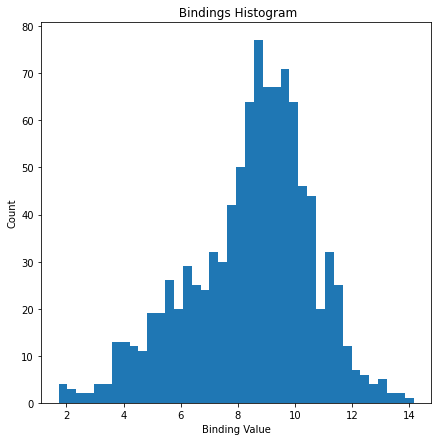

In [69]:
plt.figure(figsize=(7,7))
plt.title(" Bindings Histogram")
plt.xlabel("Binding Value")
plt.ylabel("Count")
plt.hist(max_llr_score, bins=40)

In [64]:
def correlation_plot(binding_scores, llr_scores):
    plt.figure(figsize=(7,7))
    plt.title("Correlation between binding strength and maximum LLR score - SIN3A")
    plt.xlabel("Binding Value")
    plt.ylabel("MAX LLR score")
    plt.scatter(binding_scores, llr_scores)
    plt.savefig('correlation.pdf')

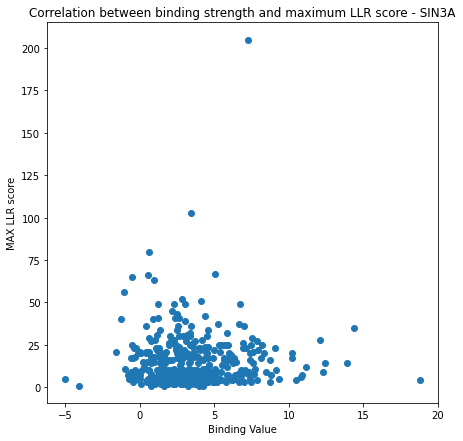

In [67]:
correlation_plot(max_llr_score_test, y_true_test)

In [48]:
len(max_llr_score)

1000

In [49]:
len(y_true)

1000

In [68]:
atcg_ratio

array([0.27806587, 0.22206387, 0.22169261, 0.27817764])

In [45]:
sequence

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])

In [46]:
len(sequence)

501000

In [16]:
len(train_set)

800

In [12]:
for data in train_loader:
    X, y = data 
    print(X.shape)
    print(y.shape)
    break

torch.Size([100, 1, 501, 4])
torch.Size([100, 1])


In [53]:
def plot_binding_histogram(data_loader, data_name):
    binding_values = []
    for data in data_loader:
        _, y = data
        binding_values.extend(torch.reshape(y, (-1,))) 
    binding_values = torch.stack(binding_values)
    plt.figure(figsize=(7,7))
    plt.title(data_name + " Bindings Histogram")
    plt.xlabel("Binding Value")
    plt.ylabel("Count")
    plt.hist(binding_values, bins=40)
    plt.axvline(binding_values.median(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(binding_values.mean(), color='r', linestyle='dashed', linewidth=1)
    plt.text(11,200,'Median',rotation=90)
    plt.text(20,200,'Mean',rotation=90, color='r')
    plt.savefig('median_mean.pdf')

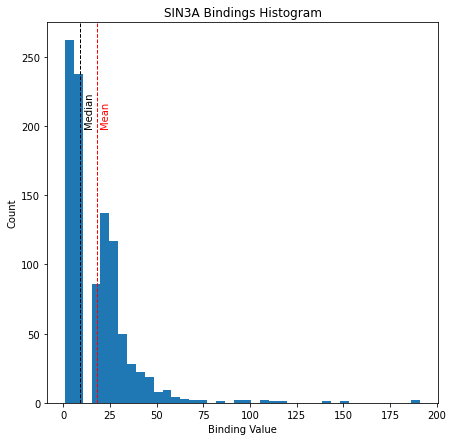

In [54]:
plot_binding_histogram(train_loader, "SIN3A")

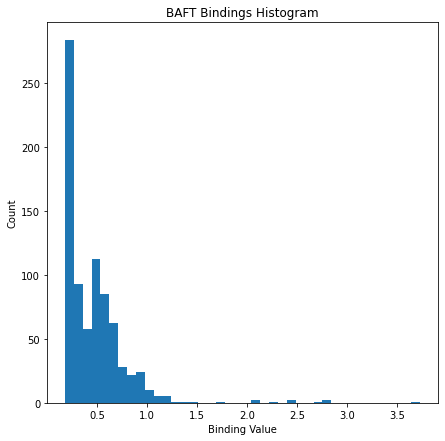

In [ ]:
plot_binding_histogram(train_loader, "BAFT")

In [ ]:
class BindingPredictionCNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=10, kernel_size=(20, 4), stride=1)
        self.conv2 = Conv1d(in_channels=10, out_channels=20, kernel_size=14, stride=1)
        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)

        self.fc1 = Linear(in_features=30*105, out_features=1500)
        self.fc2 = Linear(in_features=1500, out_features=250)
        self.out = Linear(in_features=250, out_features=1)

    def forward(self, x):
        x = F.relu((self.conv1(x)).squeeze())
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [ ]:
model = BindingPredictionCNN()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


In [ ]:
def train(net, train_loader, val_loader, optimizer, criterion, epoch_num=100):
    train_log = []
    val_log = []

    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
            x, y = x.to(device), y.to(device)        
            optimizer.zero_grad()
            outputs = net(x)
            loss = criterion(outputs.float(), y.float())      
            loss.backward()                
            optimizer.step()        
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        print('============ epoch %d =============' %epoch)
        print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')

        test_loss = []
        net.eval()
        with torch.no_grad():                
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):         
                x, y = x.to(device), y.to(device)        
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())            
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss)) 
        print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
    return train_log, val_log

In [ ]:
train_log, val_log = train(model, train_loader, val_loader, optimizer, criterion)

In [ ]:
plot_loss(train_log, val_log, 100)

In [ ]:
def test(net, test_loader):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():                
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):         
            x_input, labels = x_input.to(device), labels.to(device)        
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

In [ ]:
def plot_loss(train_log, val_log, epoch_num):
    plt.figure(figsize=(7,7))
    plt.plot(range(1, epoch_num + 1), train_log, color='C0', label='training')
    plt.plot(range(1, epoch_num + 1), val_log, color='C1', label='validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('MSE Loss')
    plt.legend(loc='best')
    plt.show()

In [ ]:
y_true, y_pred = test(model, test_loader)

In [ ]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

# Classification

In [16]:
binding_threshold = np.median(binding_values)

In [17]:
binding_threshold

0.386426

In [ ]:
y_pred_binary = (y_pred > binding_threshold) * 1
y_true_binary = (y_true > binding_threshold) * 1

In [ ]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)

In [ ]:
classification_statistics(y_true_binary, y_pred_binary)

[[ 80 114]
 [ 94 112]]
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       194
           1       0.50      0.54      0.52       206

    accuracy                           0.48       400
   macro avg       0.48      0.48      0.48       400
weighted avg       0.48      0.48      0.48       400

=== Statistics ===
Test Accuracy: 0.480
Test Sensitivity: 0.544
Test Specificity: 0.412
Test F1-Score: 0.519


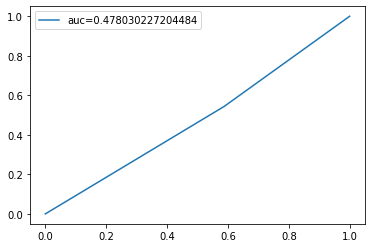

In [ ]:
fpr, tpr, _ = roc_curve(y_true_binary,  y_pred_binary)
auc = roc_auc_score(y_true_binary, y_pred_binary)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend()
plt.show()